In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt

import gzip
import os

import timeit


In [ ]:
def data_import_bases(stats = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]):

    """
    Returns a cleaned dataframe with all the military installations.

            Parameters:
                        states (list): list of stats you want to see bases off

            Data:
                        https://public.opendatasoft.com/explore/dataset/military-bases/export/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6Im1pbGl0YXJ5LWJhc2VzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJvYmplY3RpZF8xIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0ZGNTE1QSJ9XSwieEF4aXMiOiJjb21wb25lbnQiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D&location=6,37.78808,-111.09375&basemap=jawg.light

            Returns:
                        bases_df (DataFrame): 
    """

    # Choose columns we need
    data_columns = ['Geo Point', 'COMPONENT', 'Site Name', 'State Terr', 'Oper Stat']

    # read in alle the military bases - seperator ';'
    bases_df = pd.read_csv('./data/military-bases.csv', sep=';', usecols = data_columns )

    # rename columns for easier use
    bases_df.rename(columns={'Geo Point': 'geoPoint', 'COMPONENT': "component", 'Site Name': 'name', 'State Terr': 'state', 'Oper Stat': 'status'}, inplace = True)

    # checking it there is only Active and Inaktive
    #bases_df[(bases_df.status != 'Active') & (bases_df.status != 'Inactive')]

    # drop all Inaktive bases
    bases_df = bases_df[bases_df.status != 'Inactive']

    # convert geo points
    bases_df[['lat', 'lon']] = bases_df.geoPoint.str.split(',', expand = True).astype('float64')
    bases_df.geoPoint = list(zip(bases_df.lat, bases_df.lon))
    bases_df.drop(columns = ['lat', 'lon'], inplace =  True)

    # filter by list

    bases_df = bases_df[bases_df.state.isin(stats)]

    return bases_df

In [ ]:
west_coast = ["Alaska", "California", "Guam", "Hawaii", "Oregon", "Washington"]

data_import_bases(west_coast)

In [ ]:
west_coast = ["Alaska", "California", "Guam", "Hawaii", "Oregon", "Washington"]
data_df = data_import_bases(west_coast)

# folium Map centered on Glasgow Hall
nps_lat = 36.598802
nps_lon = -121.877178

# Create a map object
# Specify center location, and starting zoom level (0 to 18)
map = folium.Map(location=[nps_lat, nps_lon], zoom_start = 4, control_scal = True, tiles = "Cartodb Positron")

coord_list = data_df.geoPoint

popups = ['<b>Base:</b><br>{}<br><b>Altitude:</b><br>{}'.format(name, 'Null') for (name) in data_df.name.values]

marker_cluster = MarkerCluster(
    locations = coord_list,
    popups = popups,
    name='US Bases & Tide-sensors',
    overlay=True,
    control=True
)

marker_cluster.add_to(map)

folium.LayerControl().add_to(map)
    
map

In [ ]:
def data_import_tidel_sensors():

    sensor_information_dict = dict()
    csv_header = list()
    sensor_data_df = pd.DataFrame()

    for idx, file in enumerate(os.listdir('./data/tide_sensors/.')):

        with gzip.open('./data/tide_sensors/' + file, 'rt') as file_in:
            
            # Reading in header
            sensor_information_file = file_in.readlines()[0:10]

        if len(csv_header) == 0:
            # Retrieving the header for csv
            csv_header = sensor_information_file[-1].removeprefix('// ').removesuffix('\n').split(',')
            csv_header = [item.strip() for item in csv_header]

        # Getting metadata for the sensor
        for line in sensor_information_file[:-4]:
            
            name, value = line.removeprefix('// ').strip().split(':')

            if name in sensor_information_dict:
                sensor_information_dict[name].append(value)
            else :
                sensor_information_dict[name] = [value]
        
        sensor_data_df_temp = pd.read_csv('./data/tide_sensors/' + file, skiprows=10, sep='\t', header=None, usecols=[0,1])
        sensor_data_df_temp.columns = csv_header[:2]
        sensor_data_df_temp['NOS ID'] = int(sensor_information_dict.get('NOS ID')[idx])
        sensor_data_df_temp['datetime [ISO8601]'] = pd.to_datetime(sensor_data_df_temp['datetime [ISO8601]'], format='ISO8601')
        sensor_data_df = pd.concat([sensor_data_df, sensor_data_df_temp])

    # Creating a df from the metadata
    sensor_information_df = pd.DataFrame(sensor_information_dict)

    sensor_information_df = sensor_information_df.assign(geoPoint = list(zip(sensor_information_df.Latitude.astype('float64'), sensor_information_df.Longitude.astype('float64'))))
    sensor_information_df.drop(columns = ['Latitude', 'Longitude'], inplace =  True)

    return sensor_information_df, sensor_data_df   

In [ ]:
sensor_information_df, sensor_data_df = data_import_tidel_sensors()

In [ ]:
sensor_data_df.tail()


In [ ]:
sensor_data_df.head()


In [ ]:
sensor_data_df.describe()

In [ ]:
sensor_data_df.info()

In [ ]:
len(sensor_data_df)

In [ ]:
tide_sensor_df = sensor_data_df

In [ ]:
tide_sensor_df.groupby('NOS ID').head()

In [ ]:
tide_sensor_df.columns

In [ ]:
#curated_tide_sensor_min_df = tide_sensor_df.groupby(['NOS ID', tide_sensor_df['datetime [ISO8601]'].month]).aggregate({: 'min'})
tide_sensor_df = tide_sensor_df[tide_sensor_df['waterlevel_quality_controlled [m]'] != 9999]


curated_tide_sensor_mean_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].mean()
curated_tide_sensor_min_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].min()
curated_tide_sensor_max_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].max()


In [ ]:
curated_tide_sensor_mean_df.head()

In [ ]:
curated_tide_sensor_min_df.head()

In [ ]:
curated_tide_sensor_max_df.head()

In [ ]:
# Remove all rows with 9999
tide_sensor_df = tide_sensor_df[tide_sensor_df['waterlevel_quality_controlled [m]'] != 9999]
tide_sensors = tide_sensor_df['NOS ID'].unique()

# Group by NOS ID and month
curated_tide_sensor_mean_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].mean()
curated_tide_sensor_min_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].min()
curated_tide_sensor_max_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='M')])['waterlevel_quality_controlled [m]'].max()

# Reset index
curated_tide_sensor_mean_df = curated_tide_sensor_mean_df.reset_index()
curated_tide_sensor_min_df = curated_tide_sensor_min_df.reset_index()
curated_tide_sensor_max_df = curated_tide_sensor_max_df.reset_index()

In [ ]:
import datetime as dt

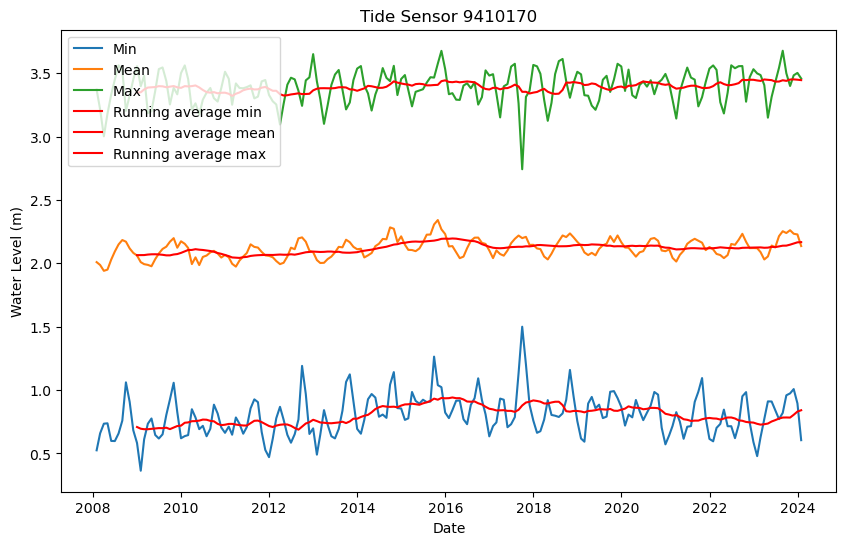

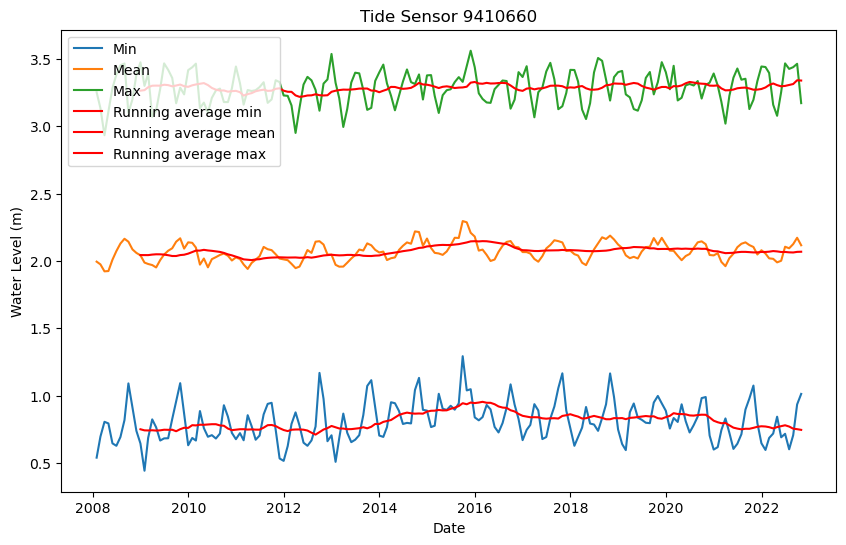

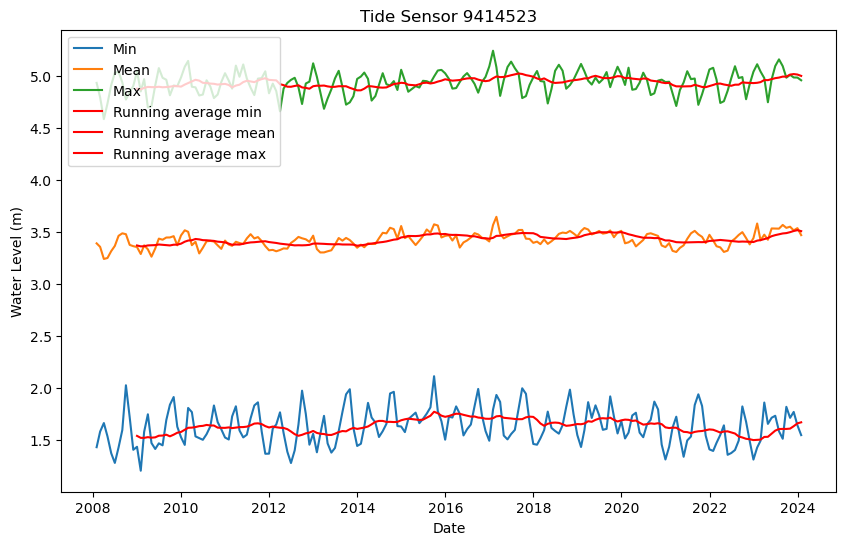

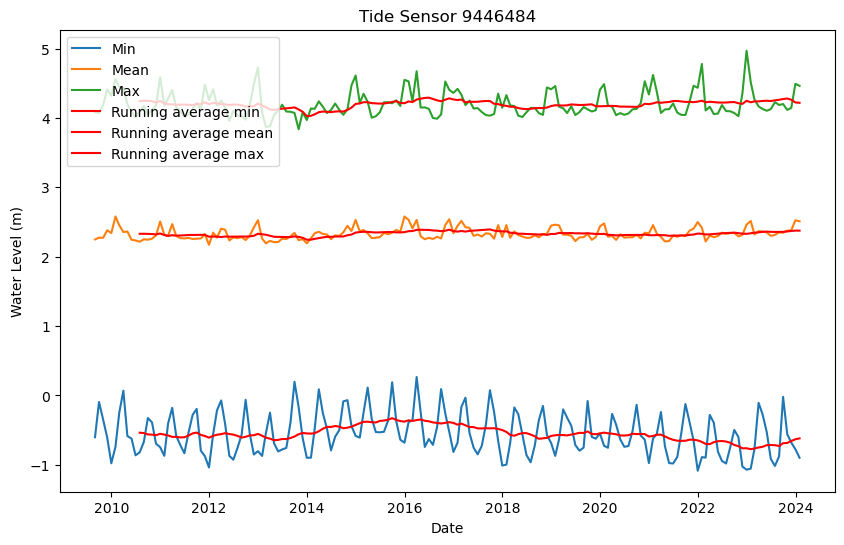

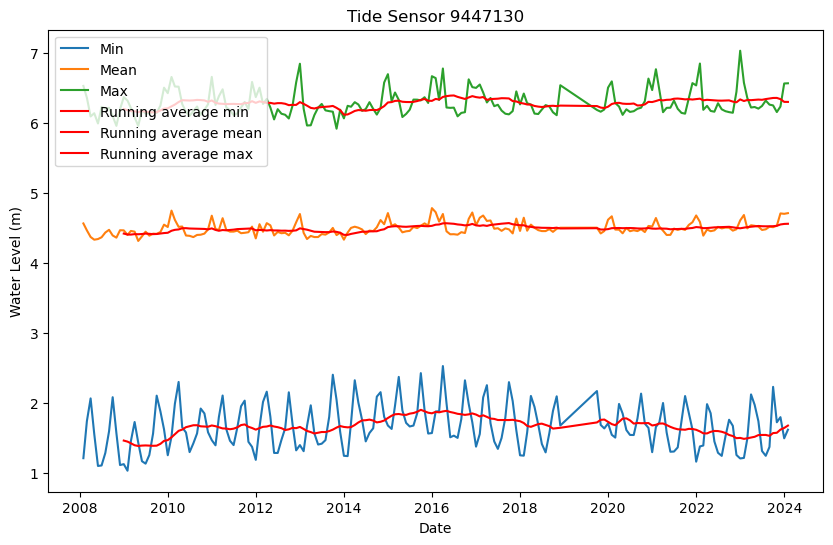

In [77]:
for sensor in tide_sensors:

    # Get the sensor data
    sensor_data = curated_tide_sensor_mean_df[curated_tide_sensor_mean_df['NOS ID'] == sensor]

    # Get the min and max
    sensor_data_min = curated_tide_sensor_min_df[curated_tide_sensor_min_df['NOS ID'] == sensor]
    sensor_data_max = curated_tide_sensor_max_df[curated_tide_sensor_max_df['NOS ID'] == sensor]

    # Merge the data
    sensor_data = sensor_data.merge(sensor_data_min[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')
    sensor_data = sensor_data.merge(sensor_data_max[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')

    # Rename columns
    sensor_data.columns = ['NOS ID', 'datetime', 'mean', 'min', 'max']

    # Plotting min, mean, and max
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sensor_data['datetime'], sensor_data['min'], label='Min')
    ax.plot(sensor_data['datetime'], sensor_data['mean'], label='Mean')
    ax.plot(sensor_data['datetime'], sensor_data['max'], label='Max')


    # Running average
    sensor_data['ra_min'] = sensor_data['min'].rolling(window=12).mean()
    sensor_data['ra_mean'] = sensor_data['mean'].rolling(window=12).mean()
    sensor_data['ra_max'] = sensor_data['max'].rolling(window=12).mean()

    # Plotting running average
    ax.plot(sensor_data['datetime'], sensor_data['ra_min'], 'r', label='Running average min')
    ax.plot(sensor_data['datetime'], sensor_data['ra_mean'], 'r', label='Running average mean')
    ax.plot(sensor_data['datetime'], sensor_data['ra_max'], 'r', label='Running average max')

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level (m)')
    ax.set_title(f'Tide Sensor {sensor}')
    ax.legend()

    # Save the plot as an image file
    #fig.savefig('./plots/plot_' + str(sensor) + '.png')
    
    plt.show()

In [ ]:
#pip install pyhigh

In [ ]:
from pyhigh import get_elevation


In [ ]:
pyhigh --lat 36.52011 --lon -118.671